# Sivolobtsev Roman task_2 Wargaming Forge

## Выгрузка данных, импорт библиотек

In [616]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score
from sklearn import cross_validation

In [617]:
train = pd.read_csv('train.csv', encoding='utf-8', lineterminator='\n')
test = pd.read_csv('test.csv', encoding='utf-8', lineterminator='\n')

In [618]:
train[:10]

,Id,Target,Duration,Language,Country,Rating,Action,Adventure,Animation,Biography,...,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,Poster
0,1,0,139,English,France,PG-13,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1.jpg
1,2,0,90,English,USA,R,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2.jpg
2,3,0,103,Mandarin,China,R,1,1,0,0,...,0,0,0,0,0,0,0,0,0,3.jpg
3,4,0,108,Dzongkha,Australia,NaN,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4.jpg
4,5,0,122,English,USA,PG-13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,5.jpg
5,6,0,113,English,USA,PG,0,1,0,1,...,0,0,0,0,0,0,0,0,0,6.jpg
6,7,0,125,German,Germany,NaN,0,0,0,1,...,0,0,0,1,0,0,0,1,0,7.jpg
7,8,0,70,English,USA,Approved,0,0,1,0,...,0,0,0,0,0,0,0,0,0,8.jpg
8,9,0,96,English,UK,R,0,0,0,0,...,0,0,0,1,0,0,0,0,0,9.jpg
9,10,1,95,English,USA,PG-13,0,0,0,0,...,0,0,0,1,0,0,0,0,0,10.jpg


In [619]:
# Уберём Id, который не понадобится для обучения.
test_ID = pd.DataFrame(test["Id"])

del train["Id"]
del test["Id"]

train_Y = train["Target"]
train_X = train.drop(["Target"], axis=1)

## Жанры, рейтинг, длительность и страна производства

In [620]:
train[:10]

,Target,Duration,Language,Country,Rating,Action,Adventure,Animation,Biography,Crime,...,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,Poster
0,0,139,English,France,PG-13,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1.jpg
1,0,90,English,USA,R,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2.jpg
2,0,103,Mandarin,China,R,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.jpg
3,0,108,Dzongkha,Australia,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.jpg
4,0,122,English,USA,PG-13,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,5.jpg
5,0,113,English,USA,PG,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,6.jpg
6,0,125,German,Germany,NaN,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,7.jpg
7,0,70,English,USA,Approved,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,8.jpg
8,0,96,English,UK,R,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,9.jpg
9,1,95,English,USA,PG-13,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,10.jpg


In [621]:
 # Заменем обекты Nan на текст None
train = train.replace(np.nan, 'None')
test = test.replace(np.nan, 'None')

# Выдерним название имеющихся жанров
genres = [x for x in train.columns[train.dtypes=='int64'] if x!="Duration"]
genres

['Target',
 'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

### Рейтинг

In [622]:
train['Rating'].value_counts()

R            1601
PG-13        1111
PG            530
None          113
G              86
Not Rated      80
Approved       40
Unrated        38
Passed          8
X               7
NC-17           5
TV-G            5
TV-14           4
GP              4
M               2
TV-MA           1
Name: Rating, dtype: int64

In [623]:
# Проверка на то, что в тестовой выборке нету новых рейтингов.
set(test['Rating'].unique()) <= set(train['Rating'].unique())

True

Я не разбираюсь в рейтингах фильмов, и возможно здесь есть одинаковая категория которая названа по разному. Но очевидно, что объекты с полями "None", "Not Rated", "Unrated" означают об отсутствии рейтинга у фильма. Объеденим их под одну категорию.

In [624]:
train['Rating'] = train['Rating'].replace(["None", "Not Rated", "Unrated"], "No Rating")
test['Rating'] = test['Rating'].replace(["None", "Not Rated", "Unrated"], "No Rating")

In [625]:
ratings = train['Rating'].unique()
for rating in ratings:
    train["rating_" + rating] = [1 if x==rating else 0 for x in train['Rating']]
    test["rating_" + rating] = [1 if x==rating else 0 for x in test['Rating']]

In [626]:
train[:10]

,Target,Duration,Language,Country,Rating,Action,Adventure,Animation,Biography,Crime,...,rating_Approved,rating_G,rating_Passed,rating_GP,rating_X,rating_TV-14,rating_NC-17,rating_TV-G,rating_M,rating_TV-MA
0,0,139,English,France,PG-13,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,90,English,USA,R,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,103,Mandarin,China,R,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,108,Dzongkha,Australia,No Rating,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,122,English,USA,PG-13,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,113,English,USA,PG,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,0,125,German,Germany,No Rating,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,0,70,English,USA,Approved,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
8,0,96,English,UK,R,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,95,English,USA,PG-13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [627]:
ratings = "rating_" + train['Rating'].unique()

def percent(x):
    if x.shape[0]!=0:
        return 100*sum(x)/x.shape[0]
    else:
        return 0

genre_rating_cor = pd.DataFrame(index=genres)
genre_rating_cor['genre_avarage'] = [percent(train[genre]) for genre in genres]

for rating in ratings:
    genre_rating_cor[rating] = [percent(train[train[rating]==1][genre]) for genre in genres]
    
genre_rating_cor

,genre_avarage,rating_PG-13,rating_R,rating_No Rating,rating_PG,rating_Approved,rating_G,rating_Passed,rating_GP,rating_X,rating_TV-14,rating_NC-17,rating_TV-G,rating_M,rating_TV-MA
Target,38.404402,39.333933,32.792005,29.004329,55.471698,27.5,59.302326,25.0,0.0,42.857143,25.0,20.0,80.0,0.0,0.0
Action,23.218707,31.143114,21.923798,12.554113,19.433962,10.0,9.302326,0.0,25.0,14.285714,25.0,0.0,0.0,0.0,0.0
Adventure,18.789546,22.682268,7.058089,8.658009,45.471698,22.5,52.325581,12.5,25.0,0.000000,25.0,0.0,0.0,0.0,0.0
Animation,5.034388,0.720072,0.687071,1.731602,20.754717,5.0,54.651163,0.0,0.0,0.000000,0.0,0.0,20.0,0.0,0.0
Biography,6.134801,6.480648,6.558401,2.164502,5.849057,7.5,2.325581,25.0,25.0,0.000000,0.0,20.0,0.0,50.0,0.0
Crime,17.689133,12.871287,27.295440,11.688312,5.094340,7.5,1.162791,0.0,50.0,0.000000,0.0,40.0,0.0,50.0,0.0
Documentary,2.200825,1.260126,1.186758,11.688312,2.641509,0.0,5.813953,0.0,0.0,0.000000,0.0,20.0,0.0,0.0,0.0
Drama,51.664374,49.054905,58.838226,59.740260,35.094340,57.5,30.232558,62.5,50.0,28.571429,50.0,40.0,60.0,50.0,100.0
Family,10.949106,1.440144,0.187383,4.329004,55.094340,17.5,76.744186,0.0,0.0,0.000000,0.0,0.0,80.0,0.0,0.0
Fantasy,12.324622,14.131413,5.496565,6.493506,28.301887,7.5,36.046512,12.5,0.0,28.571429,0.0,20.0,0.0,0.0,0.0


По большей части средняя встречаемость жанра в выобрке приблизительно равна и средней встречаемости жанра в конкретной рейтинговой категории. Однако некоторые комбинации дают значения сильно отличающиеся от этого. Посмотрим график исключительно прогнозируемой переменной.

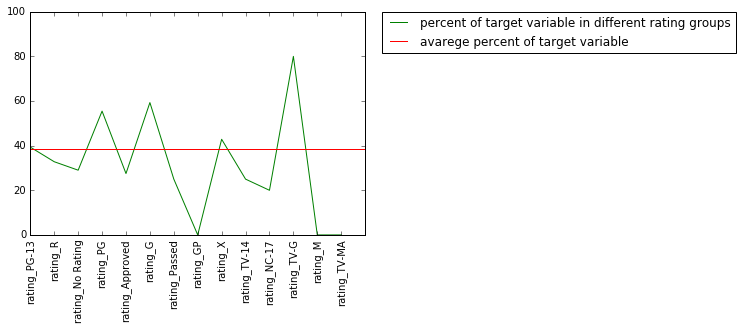

In [628]:
xlim = len(genre_rating_cor.loc["Target", ratings])
plt.plot(np.arange(xlim), genre_rating_cor.loc["Target", ratings], 'g', label='percent of target variable in different rating groups')
plt.plot([0, xlim], [genre_rating_cor.loc["Target", "genre_avarage"], genre_rating_cor.loc["Target", "genre_avarage"]], 'r', label='avarege percent of target variable')
        
plt.xticks(np.arange(xlim), ratings, rotation='vertical')    
plt.ylim(0, 100)
plt.xlim(0, xlim)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Вроде как есть явные зависимости в некоторых рейтинговых категориях, заоодно взглянем на коэффициент кореляции.

In [629]:
train[np.append(ratings, "Target")].corr()["Target"]

rating_PG-13        0.012680
rating_R           -0.102377
rating_No Rating   -0.050347
rating_PG           0.144979
rating_Approved    -0.023649
rating_G            0.066886
rating_Passed      -0.012944
rating_GP          -0.026208
rating_X            0.004021
rating_TV-14       -0.009147
rating_NC-17       -0.014044
rating_TV-G         0.031740
rating_M           -0.018527
rating_TV-MA       -0.013099
Target              1.000000
Name: Target, dtype: float64

In [630]:
del train['Rating']
del test['Rating']

### Страны

In [631]:
# Проверка на то, что в тестовой выборке нету новых стран.
set(test['Country'].unique()) <= set(train['Country'].unique())

False

Очень много стран, с которых всего по 1 фильму. Поэтому совместим страны в которых меньше 10 фильмов в обучающей выборке как "Others".

In [632]:
def threshold_filter(data, threshold):
    return data[data > threshold]

countries = threshold_filter(train['Country'].value_counts() + test['Country'].value_counts(), 10).index.values

train['Country'] = [country if country in countries else "others" for country in train['Country']]
test['Country'] = [country if country in countries else "others" for country in test['Country']]
countries = np.append(countries, 'others')

In [633]:
# Проверка на то, что в тестовой выборке нету новых стран.
set(test['Country'].unique()) <= set(train['Country'].unique())

True

In [634]:
countries = train['Country'].unique()
for country in countries:
    train['country_' + country] = [1 if x==country else 0 for x in train['Country']]
    test['country_' + country] = [1 if x==country else 0 for x in test['Country']]

In [635]:
countries = "country_" + train['Country'].unique()

genre_country_cor = pd.DataFrame(index=genres)
genre_country_cor['genre_avarage'] = [percent(train[genre]) for genre in genres]

for country in countries:
    genre_country_cor[country] = [percent(train[train[country]==1][genre]) for genre in genres]
    
genre_country_cor

,genre_avarage,country_France,country_USA,country_China,country_Australia,country_Germany,country_UK,country_Canada,country_others,country_Ireland,country_Spain,country_New Zealand,country_Denmark,country_Mexico,country_Japan,country_India,country_Italy,country_South Korea,country_Hong Kong
Target,38.404402,28.448276,41.502553,16.666667,29.268293,31.578947,29.051988,36.559140,21.951220,40.0,10.714286,0.000000,12.5,40.0,25.00,38.095238,29.411765,30.0,63.636364
Action,23.218707,18.965517,23.267688,61.111111,29.268293,23.684211,18.960245,22.580645,20.731707,20.0,7.142857,44.444444,25.0,10.0,50.00,28.571429,11.764706,60.0,90.909091
Adventure,18.789546,12.931034,18.781911,38.888889,31.707317,17.105263,22.018349,10.752688,18.292683,0.0,14.285714,44.444444,12.5,20.0,43.75,14.285714,5.882353,0.0,9.090909
Animation,5.034388,5.172414,5.288111,5.555556,4.878049,3.947368,3.058104,2.150538,6.097561,0.0,7.142857,0.000000,12.5,0.0,25.00,0.000000,0.000000,0.0,18.181818
Biography,6.134801,9.482759,5.032823,0.000000,12.195122,7.894737,14.373089,4.301075,8.536585,10.0,7.142857,11.111111,0.0,0.0,0.00,0.000000,0.000000,0.0,9.090909
Crime,17.689133,25.000000,17.833698,5.555556,7.317073,25.000000,17.125382,17.204301,12.195122,30.0,10.714286,22.222222,12.5,10.0,6.25,4.761905,23.529412,10.0,27.272727
Documentary,2.200825,3.448276,2.188184,0.000000,0.000000,2.631579,2.140673,2.150538,4.878049,0.0,0.000000,0.000000,12.5,0.0,0.00,0.000000,0.000000,0.0,0.000000
Drama,51.664374,64.655172,48.650620,61.111111,53.658537,52.631579,60.856269,50.537634,68.292683,60.0,67.857143,77.777778,75.0,90.0,43.75,76.190476,70.588235,90.0,27.272727
Family,10.949106,7.758621,11.706783,5.555556,14.634146,11.842105,8.256881,7.526882,10.975610,0.0,7.142857,11.111111,0.0,0.0,18.75,0.000000,0.000000,0.0,27.272727
Fantasy,12.324622,8.620690,12.983224,11.111111,12.195122,14.473684,10.397554,10.752688,8.536585,0.0,7.142857,33.333333,12.5,0.0,12.50,4.761905,0.000000,10.0,27.272727


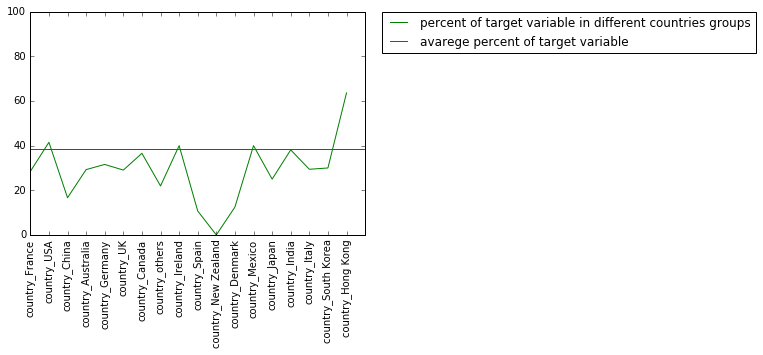

In [636]:
xlim = len(genre_country_cor.loc["Target", countries])
plt.plot(np.arange(xlim), genre_country_cor.loc["Target", countries], 'g', label='percent of target variable in different countries groups')
plt.plot([0, xlim], [genre_country_cor.loc["Target", "genre_avarage"], genre_country_cor.loc["Target", "genre_avarage"]], 'r', label='avarege percent of target variable')
        
plt.xticks(np.arange(xlim), countries, rotation='vertical')    
plt.ylim(0, 100)
plt.xlim(0, xlim)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Визиально не видно зависимости между странами и комедиями. В принципе так и есть в жизни - разные страны снимают жанры разного типа. И нету страны которая преимущественно снимает(не снимает) комедии.

In [637]:
train[np.append(countries, "Target")].corr()["Target"]

country_France        -0.037166
country_USA            0.111621
country_China         -0.031529
country_Australia     -0.020063
country_Germany       -0.020507
country_UK            -0.060457
country_Canada        -0.006148
country_others        -0.051392
country_Ireland        0.001723
country_Spain         -0.050161
country_New Zealand   -0.039339
country_Denmark       -0.025014
country_Mexico         0.001723
country_Japan         -0.018325
country_India         -0.000485
country_Italy         -0.012674
country_South Korea   -0.009076
country_Hong Kong      0.028582
Target                 1.000000
Name: Target, dtype: float64

In [638]:
del train['Country']
del test['Country']

### Языки

In [639]:
# Проверка на то, что в тестовой выборке нету новых стран.
set(test['Language'].unique()) <= set(train['Language'].unique())

False

С языками та же история что и со странами, поэтому дропаем маловстречаемые.

In [640]:
languages = threshold_filter(train['Language'].value_counts() + test['Language'].value_counts(), 5).index.values

train['Language'] = [language if language in languages else "others" for language in train['Language']]
test['Language'] = [language if language in languages else "others" for language in test['Language']]
languages = np.append(languages, 'others')

In [641]:
# Проверка на то, что в тестовой выборке нету новых стран.
set(test['Language'].unique()) <= set(train['Language'].unique())

True

In [642]:
languages = train['Language'].unique()
for language in languages:
    train['language_' + language] = [1 if x==language else 0 for x in train['Language']]
    test['language_' + language] = [1 if x==language else 0 for x in test['Language']]

In [643]:
languages = "language_" + train['Language'].unique()

genre_language_cor = pd.DataFrame(index=genres)
genre_language_cor['genre_avarage'] = [percent(train[genre]) for genre in genres]

for language in languages:
    genre_language_cor[language] = [percent(train[train[language]==1][genre]) for genre in genres]
    
genre_language_cor

,genre_avarage,language_English,language_Mandarin,language_others,language_German,language_Portuguese,language_French,language_Russian,language_Spanish,language_Hindi,language_Japanese,language_Korean,language_Cantonese
Target,38.404402,39.351988,11.111111,20.588235,13.333333,0.0,38.181818,12.5,17.241379,40.0,9.090909,33.333333,66.666667
Action,23.218707,23.534610,72.222222,16.176471,0.000000,0.0,3.636364,12.5,3.448276,20.0,45.454545,50.000000,83.333333
Adventure,18.789546,19.086892,22.222222,14.705882,6.666667,25.0,5.454545,50.0,13.793103,10.0,54.545455,0.000000,0.000000
Animation,5.034388,5.066274,0.000000,2.941176,0.000000,0.0,5.454545,25.0,3.448276,0.0,27.272727,0.000000,0.000000
Biography,6.134801,6.215022,5.555556,5.882353,13.333333,0.0,7.272727,0.0,3.448276,0.0,0.000000,0.000000,0.000000
Crime,17.689133,17.997054,11.111111,10.294118,13.333333,50.0,18.181818,0.0,13.793103,5.0,9.090909,16.666667,33.333333
Documentary,2.200825,2.091311,0.000000,7.352941,0.000000,0.0,7.272727,0.0,0.000000,0.0,0.000000,0.000000,0.000000
Drama,51.664374,50.044183,77.777778,77.941176,86.666667,100.0,69.090909,50.0,82.758621,75.0,63.636364,100.000000,16.666667
Family,10.949106,11.281296,0.000000,5.882353,0.000000,0.0,9.090909,25.0,3.448276,0.0,18.181818,0.000000,16.666667
Fantasy,12.324622,12.754050,5.555556,5.882353,0.000000,0.0,9.090909,12.5,3.448276,0.0,18.181818,0.000000,16.666667


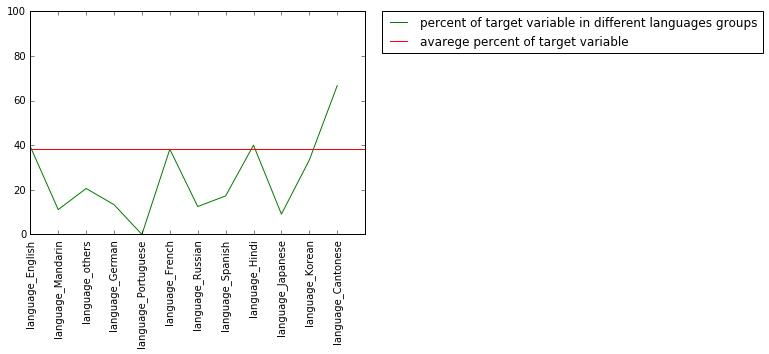

In [644]:
xlim = len(genre_language_cor.loc["Target", languages])
plt.plot(np.arange(xlim), genre_language_cor.loc["Target", languages], 'g', label='percent of target variable in different languages groups')
plt.plot([0, xlim], [genre_language_cor.loc["Target", "genre_avarage"], genre_language_cor.loc["Target", "genre_avarage"]], 'r', label='avarege percent of target variable')
        
plt.xticks(np.arange(xlim), languages, rotation='vertical')    
plt.ylim(0, 100)
plt.xlim(0, xlim)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Самая большая группа языков - английский, имеет почти такой же процент встречаемости комедий, как и среди других языков. Языки - не самый лучший признак, и предположительно, в конце он окажется вовсе не информативным.

In [645]:
train[np.append(languages, "Target")].corr()["Target"]

language_English       0.073277
language_Mandarin     -0.039587
language_others       -0.050577
language_German       -0.033182
language_Portuguese   -0.026208
language_French       -0.000567
language_Russian      -0.025014
language_Spanish      -0.039021
language_Hindi         0.002440
language_Japanese     -0.033205
language_Korean       -0.004240
language_Cantonese     0.023628
Target                 1.000000
Name: Target, dtype: float64

In [646]:
del train['Language']
del test['Language']

### Длительность

Рассмотрим зависимость жанра от длительности фильма. 

In [647]:
train_genres = {}
for g in genres:
    train_genres[g] = train[train[g]==1]["Duration"].sort_values().tolist()

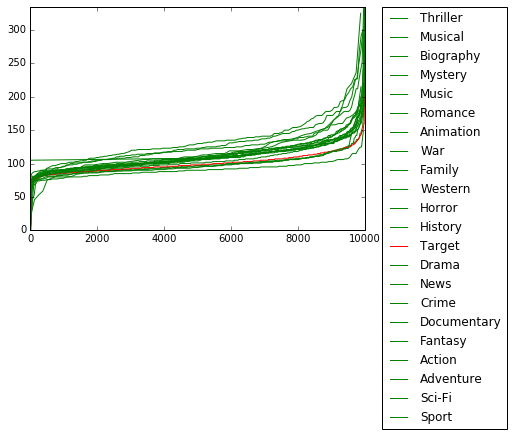

In [648]:
for genre in train_genres:
    if genre=="Target":
        colour = "r"
    else:
        colour = "g"    
    plt.plot(np.arange(0, 10000, 10001/len(train_genres[genre])), train_genres[genre], colour, label=genre)
        
plt.ylim(0, train['Duration'].max())
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Жанров очень много и поместить зависимость жанра от длительности фильма на один график - не самая удачная идея(всё слеплено вместе). Однако очевидно что зависимость есть. Для этого посмотрим на коэффициент корреляции между переменными. Так же посмотрим график между рейтингом целевого жанра и остальных.

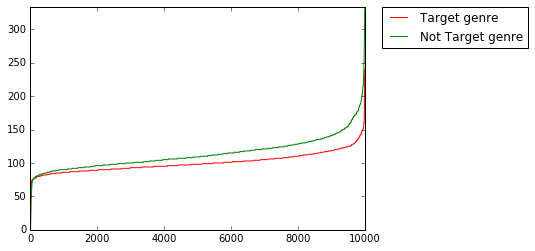

In [649]:
target_genre = train[train["Target"]==1]["Duration"].sort_values().tolist()
not_target_genre = train[train["Target"]!=1]["Duration"].sort_values().tolist()
plt.plot(np.arange(0, 10000, 10001/len(target_genre)), target_genre, "r", label="Target genre")
plt.plot(np.arange(0, 10000, 10001/len(not_target_genre)), not_target_genre, "g", label="Not Target genre")   
plt.ylim(0, train['Duration'].max())
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Длительность комедий заметно ниже. Очевидно, будет крайне информативной фичей.

In [650]:
train[['Target','Duration']].corr()

,Target,Duration
Target,1.000000,-0.284893
Duration,-0.284893,1.000000


### Жанры

In [651]:
genre_cor = [percent(train[train[genre]==1]["Target"]) for genre in genres if genre!="Target"]
    
genre_cor

[22.985781990521328,
 35.13909224011713,
 75.95628415300547,
 10.31390134529148,
 30.326594090202178,
 12.5,
 26.730564430244943,
 70.100502512562812,
 43.303571428571431,
 3.0864197530864197,
 15.681233933161954,
 47.844827586206897,
 56.179775280898873,
 10.364145658263306,
 0.0,
 53.827751196172251,
 26.666666666666668,
 39.534883720930232,
 9.2428711897738438,
 8.0,
 14.864864864864865]

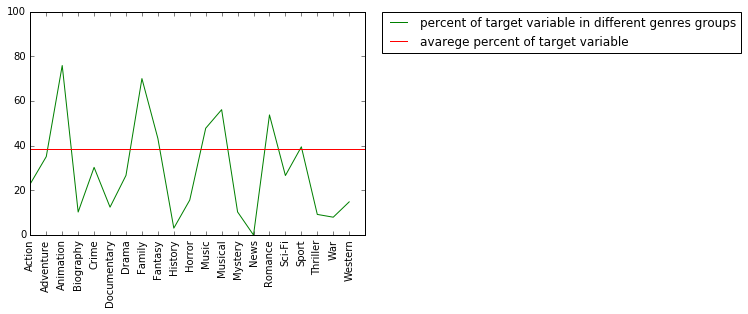

In [652]:
xlim = len(genre_cor)
plt.plot(np.arange(xlim), genre_cor, 'g', label='percent of target variable in different genres groups')
plt.plot([0, xlim], [percent(train["Target"]), percent(train["Target"])], 'r', label='avarege percent of target variable')
        
plt.xticks(np.arange(xlim), [genre for genre in genres if genre!="Target"], rotation='vertical')    
plt.ylim(0, 100)
plt.xlim(0, xlim)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [653]:
train[genres].corr()['Target']

Target         1.000000
Action        -0.174330
Adventure     -0.032293
Animation      0.177769
Biography     -0.147653
Crime         -0.076993
Documentary   -0.079898
Drama         -0.248148
Family         0.228513
Fantasy        0.037766
History       -0.156832
Horror        -0.161735
Music          0.050680
Musical        0.057900
Mystery       -0.190259
News          -0.018527
Romance        0.173307
Sci-Fi        -0.090713
Sport          0.004458
Thriller      -0.373698
War           -0.140589
Western       -0.069769
Name: Target, dtype: float64

Жанры - очень хорошие фичи, я бы даже сказал что основные. Так как явно видны комбинации с таргетировонной переменной. Так, например, "News" и "History" почти не сочетаются в комбинации с комедиями.

## Кросс-валидация

Просто KFolds на 10 фолдов. Рандомстейт фиксируем.

In [654]:
def validation(classifier, data_X, data_Y):
    
    scorer = []
    validation = cross_validation.KFold(train_X.shape[0], n_folds=10, shuffle=True, random_state=42)
    for train_index, test_index in validation:
        classifier.fit(data_X.loc[train_index], data_Y[train_index])
        proba = classifier.predict_proba(data_X.loc[test_index])
        test = classifier.predict_proba(data_X.loc[train_index])
        scorer.append([roc_auc_score(data_Y[test_index], proba[:,1]),roc_auc_score(data_Y[train_index], test[:,1])])
    return scorer

## Первые модели, без применения картинок

Воспользуемся двумя самыми популярными моделями прогнозирования - статической и структурной, по одному экземпляру из каждой. И так были выбраны логистическая регрессия и деревья принятия решений на методе градиентного спуска как самые гибкие и универсальные методы. Библиотеку используем стандартную - sklearn.

In [655]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [656]:
train_Y = train["Target"]
train_X = train.drop(["Target", 'Poster'], axis=1)

In [657]:
scorer = np.array(validation(GradientBoostingClassifier(random_state=42), train_X, train_Y))
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])
scorer

['test_score - 0.886469111058', 'test_std - 0.0248236541464']
['train_score - 0.914603235492', 'train_std - 0.00267363507485']


array([[ 0.85269452,  0.91741754],
       [ 0.89570821,  0.91342015],
       [ 0.9094428 ,  0.91289965],
       [ 0.9161703 ,  0.91001749],
       [ 0.83483392,  0.91995939],
       [ 0.89977117,  0.91265375],
       [ 0.9065627 ,  0.91342087],
       [ 0.88652806,  0.91423035],
       [ 0.87077476,  0.91637217],
       [ 0.89220469,  0.91564099]])

In [658]:
scorer = np.array(validation(LogisticRegression(random_state=42), train_X, train_Y))
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])
scorer

['test_score - 0.882019346131', 'test_std - 0.0193885809256']
['train_score - 0.890853916247', 'train_std - 0.0021135437163']


array([[ 0.84897959,  0.89455655],
       [ 0.88286724,  0.89068699],
       [ 0.89155611,  0.88938274],
       [ 0.91130423,  0.8878658 ],
       [ 0.85079906,  0.89410677],
       [ 0.88363844,  0.89095093],
       [ 0.90687135,  0.88810748],
       [ 0.87500815,  0.89176719],
       [ 0.87906178,  0.8911476 ],
       [ 0.8901075 ,  0.88996712]])

Раз жанры показали хорошие значения, то попробуем добавить их комбинации(logical AND) как отдельную фичу. На структурную модель это не должно оказать изменений, так как эти новые фичи предусматриваются её устройством, а вот на статическую модель данный метод может положительно повлиять.

In [659]:
import itertools

genres_comb = itertools.combinations([genre for genre in genres if genre!="Target"], 2)

for genre_comb in genres_comb:
    genre1, genre2 = list(genre_comb)
    train["_".join(genre_comb)] = np.logical_and(train[genre1], train[genre2])
    test["_".join(genre_comb)] = np.logical_and(test[genre1], test[genre2])

In [660]:
train_X2 = train.drop(["Target", 'Poster'], axis=1)

print("-------------GradientBoostingClassifier-------------")
scorer = np.array(validation(GradientBoostingClassifier(random_state=42), train_X2, train_Y))
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])

scorer = np.array(validation(LogisticRegression(random_state=42), train_X2, train_Y))
print("-------------LogisticRegression-------------")
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])

-------------GradientBoostingClassifier-------------
['test_score - 0.885075955056', 'test_std - 0.0261612168983']
['train_score - 0.917355452011', 'train_std - 0.00227113894989']
-------------LogisticRegression-------------
['test_score - 0.888851535286', 'test_std - 0.0217844778088']
['train_score - 0.912028071773', 'train_std - 0.00204061403211']


На градиентбустинг как и ожидалось это не повлияло, а вот логистическая регрессия дала значительно лучшие результаты, как на тестовой так и на обучающей выборке при кросс-валидации.

## Работа с изображениями

In [661]:
from PIL import Image
import os

module_dir = os.getcwd()
poster_dir = module_dir + "/posters/"

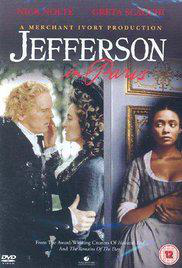

In [662]:
im = Image.open(poster_dir + "1.jpg")
im

Первая мысль которая приходит на ум - это создать палитру цветов, например 16 основных. Вытянуть доминантные цвета постеров и спроецировать на цветовую палитру. После чего получим список из основных цветов присутствующих на картинке. Работаем с RGB представлением цвета.

In [663]:
colors_dict = {"Black":(0,0,0),
"White":(255,255,255),
"Red":(255,0,0),
"Lime":(0,255,0),
"Blue":(0,0,255),
"Yellow":(255,255,0),
"Aqua":(0,255,255),
"Magenta":(255,0,255),
"Silver":(192,192,192),
"Gray":(128,128,128),
"Maroon":(128,0,0),
"Olive":(128,128,0),
"Green":(0,128,0),
"Purple":(128,0,128),
"Teal":(0,128,128),
"Navy":(0,0,128)}

In [664]:
def get_dominante_colors(image, n):
    quantized = image.quantize(colors=n)
    rgb = quantized.getpalette()[:3*n]
    
    return [rgb[i:i+3] for i in range(0, len(rgb), 3)]

In [665]:
import math 

def color_distance(c1, c2):
    (r1,g1,b1) = c1
    (r2,g2,b2) = c2
    return math.sqrt((r1 - r2)**2 + (g1 - g2)**2 + (b1 - b2)**2)

In [666]:
def refactor_img(imgs_path, colors_n, colors_dict):
    colors_name = list(colors_dict)
    colors={}
    
    for img_path in imgs_path:
        img = Image.open(poster_dir + img_path)
        img_colors = get_dominante_colors(img, colors_n)
        colors[img_path] = [sorted(colors_name, key=lambda color: color_distance(colors_dict[color], img_color))[0] for img_color in img_colors]
    
    df_imgs = pd.DataFrame(imgs_path)
    for color in colors_dict:
        df_imgs[color] = [colors[img_path].count(color) for img_path in imgs_path]
        
    return df_imgs

In [668]:
df_imgs = refactor_img(train['Poster'], 5, colors_dict)
df_imgs[:10]

,Poster,Red,Aqua,Magenta,Lime,White,Gray,Navy,Black,Olive,Purple,Maroon,Yellow,Silver,Teal,Green,Blue
0,1.jpg,0,0,0,0,0,3,1,0,0,0,0,0,1,0,0,0
1,2.jpg,0,0,0,0,0,0,0,1,2,0,1,0,1,0,0,0
2,3.jpg,0,0,0,0,0,1,0,3,0,0,0,0,1,0,0,0
3,4.jpg,0,0,0,0,0,2,1,0,0,0,0,0,1,1,0,0
4,5.jpg,0,0,0,0,3,0,0,1,0,0,0,0,1,0,0,0
5,6.jpg,0,0,0,0,0,1,0,1,0,0,1,0,2,0,0,0
6,7.jpg,0,0,0,0,0,1,0,3,0,0,1,0,0,0,0,0
7,8.jpg,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,0
8,9.jpg,0,0,0,0,0,1,0,4,0,0,0,0,0,0,0,0
9,10.jpg,0,0,0,0,1,1,0,0,0,0,0,0,2,1,0,0


In [669]:
train_X3 = pd.merge(train, refactor_img(train['Poster'], 5, colors_dict), on='Poster')

## Классификатор + доминантные цвета.

In [671]:
train_X3 = train_X3.drop(["Target", 'Poster'], axis=1)

print("-------------GradientBoostingClassifier-------------")
scorer = np.array(validation(GradientBoostingClassifier(random_state=42), train_X3, train_Y))
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])

scorer = np.array(validation(LogisticRegression(random_state=42), train_X3, train_Y))
print("-------------LogisticRegression-------------")
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])

-------------GradientBoostingClassifier-------------
['test_score - 0.892202953831', 'test_std - 0.0248358807193']
['train_score - 0.927694870032', 'train_std - 0.00220110788038']
-------------LogisticRegression-------------
['test_score - 0.895351464377', 'test_std - 0.0201802968038']
['train_score - 0.91926784958', 'train_std - 0.00196535641596']


### Увеличение количества стандартных цветов словаря цветовой палитры и доминатных цветов с картинки

Попробуем использовать более обширный набор цветов, он находится в прикреплённом файле "colors.csv". А так же увеличить количество доминантных цветов картинки с 5 до 10.

In [672]:
colors_dict2 = pd.read_csv('colors.csv', encoding='latin1', delimiter=";", index_col=0, names=["RGB"])

In [673]:
from ast import literal_eval

colors_dict2["RGB"] = [literal_eval(x) for x in colors_dict2["RGB"]]
colors_dict2 = colors_dict2.to_dict(orient='dict')["RGB"]

In [674]:
df_colors2 = refactor_img(train['Poster'], 10, colors_dict2)
train_X4 = pd.merge(train, df_colors2, on='Poster')

In [675]:
# train_X4 = train_X4.drop(["Target", 'Poster'], axis=1)

print("-------------GradientBoostingClassifier-------------")
scorer = np.array(validation(GradientBoostingClassifier(random_state=42), train_X4, train_Y))
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])

scorer = np.array(validation(LogisticRegression(random_state=42), train_X4, train_Y))
print("-------------LogisticRegression-------------")
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])

-------------GradientBoostingClassifier-------------
['test_score - 0.892134787338', 'test_std - 0.0243604605265']
['train_score - 0.93356656535', 'train_std - 0.0019287581079']
-------------LogisticRegression-------------
['test_score - 0.895253118306', 'test_std - 0.0172307702288']
['train_score - 0.931056093211', 'train_std - 0.00172682776142']


## Neural Networks. Keras.

Следующим этапом при работе с картинками были нейрононные сети. Обучить сеть распозновать образы - давольно трудоёмкая задача, но никто не запрещал пользоваться готовыми сетками. Поэтому была выбрана одна из существующих нейронных сетей для распознования образов с настроенными весами. VGG19. Идея заключается в том, чтобы взять готовую сетку и скормить ей изображения, а выходные значения одного из слоёв взять как фичи для модели.

In [676]:
from keras.applications import VGG19 

In [677]:
from keras.preprocessing import image
from keras.models import Model
# from imagenet_utils import preprocess_input

base_model = VGG19(weights='imagenet', include_top=True)
model = Model(input=base_model.input, output=base_model.get_layer('fc2').output)

In [678]:
df_VGG19_param=pd.DataFrame(columns=np.append("Poster", ["VGG19_param_" + str(i) for i in range(1,4097)]))

for i, img_path in enumerate(train['Poster']):
    img = image.load_img(poster_dir + img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    df_VGG19_param.loc[i] = np.append(img_path, model.predict(x)[0])

train2 = pd.merge(train, df_VGG19_param, on='Poster')

In [679]:
df_VGG19_param.to_csv("df_VGG19_param.csv", index=False) # долго вытягивались, чтобы не потерять

Эта сеть работает с изображениями разрешения 224х224, в то время как постеры имеют разрешение 268х182. Поэтому приходится ужимать изображения для работы с ними. Если данный метод плохо себя покажет, то в дальнейшем можно будет обрезать изображения и заполнять пустые места белым цветом.

fc2 - предпоследний слой, длинны 4096. Весомая привабка фичей. Есть подозрения что регрессия переобучится, так как фичей 4096, а экземпляров модели - 3635*0,9(10% выборки на тест при кросс-валидации).

Посмотрим как поведёт себя классификатор построенный только на фичах с нейронной сети. После чего объеденим два набора параметром для достижения лучших результатов.

In [256]:
train_X5 = df_VGG19_param.drop(['Poster'], axis=1)
print("-------------GradientBoostingClassifier-------------")
scorer = np.array(validation(GradientBoostingClassifier(random_state=42), train_X5, train_Y))
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])

scorer = np.array(validation(LogisticRegression(random_state=42), train_X5, train_Y))
print("-------------LogisticRegression-------------")
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])

-------------GradientBoostingClassifier-------------
['test_score - 0.833360677125', 'test_std - 0.0212587343531']
['train_score - 0.967953263692', 'train_std - 0.00112671623412']
-------------LogisticRegression-------------
['test_score - 0.766079802786', 'test_std - 0.0280263397495']
['train_score - 1.0', 'train_std - 0.0']


0,83 без начальных признаков - очень хороший результат. В комбинации со старыми фичами должно поднять результаты. Однако проблема регресии подтвердилась - переобучение. Связано это с тем, что объём признаков больше объёма выборки. У бустинга тоже подозрительный 0,967 на обучающей выборке, нужно попробывать вытягивать меньше фичей с картинок.

In [449]:
train_X6 = pd.merge(train2, df_colors2, on='Poster')
train_X6 = train_X6.drop(["Target", 'Poster'], axis=1)

print("-------------GradientBoostingClassifier-------------")
scorer = np.array(validation(GradientBoostingClassifier(random_state=42), train_X6, train_Y))
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])

scorer = np.array(validation(LogisticRegression(random_state=42), train_X6, train_Y))
print("-------------LogisticRegression-------------")
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])

-------------GradientBoostingClassifier-------------
['test_score - 0.898320870917', 'test_std - 0.0202879780347']
['train_score - 0.981557038933', 'train_std - 0.00108134948559']
-------------LogisticRegression-------------
['test_score - 0.807424260123', 'test_std - 0.0270695387852']
['train_score - 1.0', 'train_std - 3.51083346858e-17']


В целом структурная модель стала лучше, а статическая стала переобучается. Как вариант можно понизить размерность фичей при помощи метода главных компонент (PCA). Для начала просто попробуем взять фичи с другого слоя и для надёжности с другой нейронной сети, например SetNet50.

In [683]:
from keras.applications import ResNet50 

model_RN = ResNet50(weights='imagenet')

img = image.load_img(poster_dir + "2.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

len(model_RN.predict(x)[0])

1000

In [684]:
df_RN_param=pd.DataFrame(columns=np.append("Poster", ["RN_param_" + str(i) for i in range(1,1001)]))

for i, img_path in enumerate(train['Poster']):
    img = image.load_img(poster_dir + img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    df_RN_param.loc[i] = np.append(img_path, model_RN.predict(x)[0])

train3 = pd.merge(train, df_RN_param, on='Poster')

In [446]:
train_X7 = pd.merge(train3, df_colors2, on='Poster')
train_X7 = train_X7.drop(["Target", 'Poster'], axis=1)

print("-------------GradientBoostingClassifier-------------")
scorer = np.array(validation(GradientBoostingClassifier(random_state=42), train_X7, train_Y))
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])

scorer = np.array(validation(LogisticRegression(random_state=42), train_X7, train_Y))
print("-------------LogisticRegression-------------")
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])

-------------GradientBoostingClassifier-------------
['test_score - 0.904471388147', 'test_std - 0.0203480834396']
['train_score - 0.974199488339', 'train_std - 0.00126153192139']
-------------LogisticRegression-------------
['test_score - 0.898325014906', 'test_std - 0.0178659876746']
['train_score - 0.936276149056', 'train_std - 0.00170786801107']


0.904 уже получше и статическая модель сильно не переобучается. Следующим шагом была идея попробывать обучать на вероятностях распознанных объектов

In [685]:
img = image.load_img(poster_dir + "2.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

decode_predictions(model_RN.predict(x), 10)[0]

[('n07565083', 'menu', 0.45798725),
 ('n06596364', 'comic_book', 0.23526044),
 ('n07248320', 'book_jacket', 0.16148363),
 ('n04476259', 'tray', 0.041323427),
 ('n06359193', 'web_site', 0.034132577),
 ('n04179913', 'sewing_machine', 0.021040408),
 ('n02871525', 'bookshop', 0.0083767856),
 ('n03598930', 'jigsaw_puzzle', 0.0047443784),
 ('n04418357', 'theater_curtain', 0.0025371055),
 ('n03291819', 'envelope', 0.0018530051)]

In [686]:
RN_obj_dict = {}
RN_dict = {}

for i, img_path in enumerate(train['Poster']):
    img = image.load_img(poster_dir + img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = decode_predictions(model_RN.predict(x), 10)[0]
    RN_obj_dict[img_path] = {obj[1]: obj[2] for obj in x}
    
    for obj in x:
        try:
            RN_dict[obj[1]]+=obj[2]
        except:
            RN_dict[obj[1]]=obj[2]
    
RN_dict_index= sorted(RN_dict, key=lambda obj: RN_dict[obj], reverse=True)
df_RN_obj = pd.DataFrame(train["Poster"], columns=np.append("Poster", ["RN_obj_" + obj for obj in RN_dict_index]))
df_RN_obj.fillna(value=0., inplace=True)

for i, img_path in enumerate(RN_obj_dict):
    for obj in RN_obj_dict[img_path]:
        if obj in RN_dict_index:
            df_RN_obj.set_value(i, "RN_obj_" + obj, RN_obj_dict[img_path][obj])
    
train4 = pd.merge(train, df_RN_obj, on='Poster')

In [404]:
train_X8 = pd.merge(train4, df_colors2, on='Poster')
train_X8 = train_X8.drop(["Target", 'Poster'], axis=1)

print("-------------GradientBoostingClassifier-------------")
scorer = np.array(validation(GradientBoostingClassifier(), train_X8, train_Y))
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])

scorer = np.array(validation(LogisticRegression(), train_X8, train_Y))
print("-------------LogisticRegression-------------")
print(["test_score - " + str(scorer[:,0].mean()), "test_std - " + str(scorer[:,0].std())])
print(["train_score - " + str(scorer[:,1].mean()), "train_std - " + str(scorer[:,1].std())])

-------------GradientBoostingClassifier-------------
['test_score - 0.88470934064', 'test_std - 0.0230953926883']
['train_score - 0.93933694163', 'train_std - 0.00157701904034']
-------------LogisticRegression-------------
['test_score - 0.889169977095', 'test_std - 0.0140395522235']
['train_score - 0.918404086433', 'train_std - 0.00140451910666']


К сожелению эта была не лучшая идея. Значения сильно упали. И у меня нету предположений почему так вышло.

## Прогноз комедий, запись в файл.

Для начала вытащим такие же признаки тестовой выборки что и для тренировочной. Раз модели на фичах разных нейронок дают схожие результаты, то в итоговой модели возьсём ансамбль двух методов.

In [606]:
df_RN_param_test=pd.DataFrame(columns=np.append("Poster", ["RN_param_" + str(i) for i in range(1,1001)]))

for i, img_path in enumerate(test['Poster']):
    img = image.load_img(poster_dir + img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    df_RN_param_test.loc[i] = np.append(img_path, model_RN.predict(x)[0])
    
df_VGG19_param_test=pd.DataFrame(columns=np.append("Poster", ["VGG19_param_" + str(i) for i in range(1,4097)]))

for i, img_path in enumerate(test['Poster']):
    img = image.load_img(poster_dir + img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    df_VGG19_param_test.loc[i] = np.append(img_path, model.predict(x)[0])

df_colors2_test = refactor_img(test['Poster'], 10, colors_dict2)

test_X = pd.merge(test, df_RN_param_test, on='Poster')
test_X = pd.merge(test_X, df_colors2_test, on='Poster')
test_X = test_X.drop(['Poster'], axis=1)
test_X2 = pd.merge(test, df_VGG19_param_test, on='Poster')
test_X2 = pd.merge(test_X2, df_colors2_test, on='Poster')
test_X2 = test_X2.drop(['Poster'], axis=1)

Я во всех своих работах фиксирую random_state=42. Это не подогнанный параметр!

In [703]:
from sklearn.ensemble import VotingClassifier

# NetSet50_param
classifier_final = GradientBoostingClassifier(n_estimators=500, random_state=42, max_depth=4)
classifier_final.fit(train_X7, train_Y)
proba = classifier_final.predict_proba(test_X)

# VGG19_fc2_param 
classifier_final = GradientBoostingClassifier(n_estimators=500, random_state=42, max_depth=4)
classifier_final.fit(train_X6, train_Y)
proba1 = classifier_final.predict_proba(test_X2)

In [708]:
answer = pd.DataFrame(test_ID, columns = ["Id"])
answer.insert(loc=1, column='Probability', value=(proba[:,1]+proba1[:,1])/2) # усреднение двух моделей
answer


,Id,Probability
0,3636,0.422210
1,3637,0.015276
2,3638,0.943806
3,3639,0.001774
4,3640,0.015944
5,3641,0.804647
6,3642,0.032007
7,3643,0.345476
8,3644,0.080553
9,3645,0.025867


In [707]:
answer.to_csv("SivolobtsevRM_task_2_prediction.csv", index=False)

## Итог

В силу моей фантазии, я переработал имеющиеся исходные данные в разного рода признаки. Которые в последствии использовал в структурной и статической моделях. На кросс-валидации были получены результаты превышающие значение в 0.9, в силу чего я надеюсь что и результаты на тестовой выборке так же перебили этот рубеж. В качестве финальной модели было выбрано усреднение двух результатов, построенных на фичах разных нейронных сетей. Я не считаю что это усреднение даст какой-то положительный результат, но раз уж эти сетки долго обрабатывали изображения, то обидно будет игнорировать какие-либо фичи.

Так же хотелось настроить параметры модели через сетку, но в конце уже не было времени считать, поэтому единственное что я сделал это увеличил количество деревьев.

In [ ]:
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'min_samples_split': [1, 2, 3], 'max_depth': [2, 3, 4], 
                     'learning_rate': [0.05, 0.1],'n_estimators': [150, 250, 500]}]

GB_classifier = GridSearchCV(GradientBoostingClassifier(random_state=42), tuned_parameters)
GB_classifier.fit(train_X7, train_Y)
print(GB_classifier.best_estimator_)